In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
from tqdm.notebook import tqdm
import datetime
import numpy as np




In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import pandas as pd
import os
from torchsummary import summary
import matplotlib.pyplot as plt


class ClagnoscoDataset(Dataset):
    def __init__(self):
        self.base_dir = r"C:\!project-dataset"
        metadata_path = os.path.join(self.base_dir, "metadata.csv")
        self.data = pd.read_csv(metadata_path)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        uid = self.data.loc[idx, 'uid']
        image_resize_path = os.path.join(self.base_dir, 'images_resize', f"{uid}.jpg")
        image_square_path = os.path.join(self.base_dir, 'images_square', f"{uid}.jpg")
        caption_path = os.path.join(self.base_dir, 'captions', f"{uid}.txt")
        embedding_path = os.path.join(self.base_dir, 'captions_emb', f"{uid}.npy")

        image = Image.open(image_resize_path).convert('RGB')
        image_square = Image.open(image_square_path).convert('RGB')
        with open(caption_path, 'r', encoding='utf-8') as f:
            caption = f.read().strip()
        embedding = np.load(embedding_path)

        return {
            'uid': uid,
            'image': image,
            'image_width': self.data.loc[idx, 'image_width'],
            'image_height': self.data.loc[idx, 'image_height'],
            'image_square': image_square,
            'caption': caption,
            'embedding': torch.tensor(embedding, dtype=torch.float16)
        }

class ClagnoscoEncoder(nn.Module):
    def __init__(
        self,
        latent_dim=512,
        embed_dim=768,
        backbone_channels=2048,
        hidden_dim=1536,
        negative_slope=0.01
    ):
        super().__init__()
        self.latent_dim_size = latent_dim
        self.embed_dim_size = embed_dim

        self.conv = nn.Sequential(
            # Conv Layer 1: kernel_size=4, stride=2, padding=1
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope, inplace=True),

            # Conv Layer 2: kernel_size=4, stride=2, padding=1
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope, inplace=True),

            # Conv Layer 3: kernel_size=3, stride=1, padding=1
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope, inplace=True),

            # Conv Layer 4: kernel_size=3, stride=1, padding=1
            nn.Conv2d(in_channels=256, out_channels=backbone_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(backbone_channels),
            nn.LeakyReLU(negative_slope, inplace=True),
        )

        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(backbone_channels, hidden_dim)
        self.act = nn.LeakyReLU(negative_slope, inplace=True)
        self.fc2 = nn.Linear(hidden_dim, latent_dim + embed_dim)

    def forward(self, x):
        B = x.size(0)
        feat = self.conv(x)
        pooled = self.pool(feat).view(B, -1)
        hidden = self.act(self.fc1(pooled))
        out = self.fc2(hidden)
        latent, emb_pred = out.split([self.latent_dim_size, self.embed_dim_size], dim=1)
        return latent, emb_pred

class ClagnoscoDecoder(nn.Module):
    def __init__(
        self,
        latent_dim=512,
        embed_dim=768,
        image_res=512,
        negative_slope=0.01
    ):
        super().__init__()
        self.input_dim = latent_dim + embed_dim + 1  # +1 for ratio
        self.init_size = image_res // 32

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 256 * self.init_size * self.init_size),
            nn.LeakyReLU(negative_slope, inplace=True),
            nn.Unflatten(1, (256, self.init_size, self.init_size)),
        )

        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1),  # 16 → 32
            nn.LeakyReLU(negative_slope, inplace=True),
            nn.ConvTranspose2d(in_channels=128, out_channels=64,  kernel_size=4, stride=2, padding=1),  # 32 → 64
            nn.LeakyReLU(negative_slope, inplace=True),
            nn.ConvTranspose2d(in_channels=64,  out_channels=32,  kernel_size=4, stride=2, padding=1),  # 64 → 128
            nn.LeakyReLU(negative_slope, inplace=True),
            nn.ConvTranspose2d(in_channels=32,  out_channels=16,  kernel_size=4, stride=2, padding=1),  # 128 → 256
            nn.LeakyReLU(negative_slope, inplace=True),
            nn.ConvTranspose2d(in_channels=16,  out_channels=3,   kernel_size=4, stride=2, padding=1),  # 256 → 512
            nn.Sigmoid()
        )
    def forward(self, latent, embed, ratio):
        """
        latent: [B, latent_dim]
        embed:  [B, embed_dim]
        ratio:  [B, 1] (e.g., torch.tensor([[1.0], [1.33], ...]))
        """
        x = torch.cat([latent, embed, ratio], dim=1)
        x = self.fc(x)
        x = self.deconv(x)
        return x

class ClagnoscoAutoencoder(nn.Module):
    def __init__(
        self,
        latent_dim=512,
        embed_dim=768,
        backbone_channels=2048,
        hidden_dim=1536,
        image_res=512,
        negative_slope=0.01
    ):
        super().__init__()
        self.encoder = ClagnoscoEncoder(
            latent_dim=latent_dim,
            embed_dim=embed_dim,
            backbone_channels=backbone_channels,
            hidden_dim=hidden_dim,
            negative_slope=negative_slope
        )
        self.decoder = ClagnoscoDecoder(
            latent_dim=latent_dim,
            embed_dim=embed_dim,
            image_res=image_res,
            negative_slope=negative_slope
        )

    def forward(self, x, ratio):
        """
        x:     [B, 3, H, W]
        ratio: [B, 1] (e.g., torch.tensor([[1.0], [1.33], ...]))
        """
        latent, embed = self.encoder(x)
        recon = self.decoder(latent, embed, ratio)
        return recon, latent, embed

enc = ClagnoscoEncoder()

img1 = torch.randn(1, 3, 128, 128)   # square
img2 = torch.randn(1, 3, 128, 256)   # rectangular

latent1, emb1 = enc(img1)
latent2, emb2 = enc(img2)

print("img1 → latent:", latent1.shape, ", emb:", emb1.shape)
print("img2 → latent:", latent2.shape, ", emb:", emb2.shape)


img1 → latent: torch.Size([1, 512]) , emb: torch.Size([1, 768])
img2 → latent: torch.Size([1, 512]) , emb: torch.Size([1, 768])


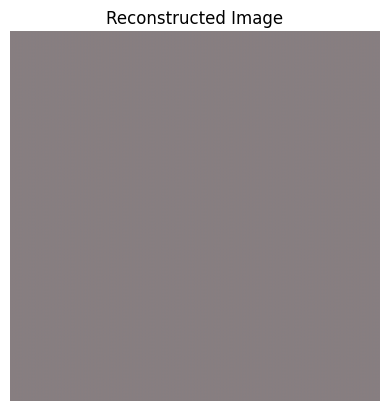

(tensor([[-8.0701e-02, -4.3529e-02,  4.9257e-02,  2.0590e-01, -1.3149e-02,
          -6.4971e-03, -7.2491e-02, -6.7959e-02,  5.4301e-02,  1.1435e-01,
          -1.7284e-02,  1.0485e-01,  1.4454e-01,  4.1949e-02, -1.6260e-01,
          -8.0337e-02, -1.8054e-01,  1.1941e-01, -6.7171e-02, -2.0356e-01,
           1.1583e-01, -7.3620e-02, -1.3368e-01,  2.8543e-02,  3.5742e-02,
          -1.1435e-02,  1.7536e-01, -5.4719e-02,  1.5899e-01, -2.5042e-03,
          -5.6105e-02, -8.3036e-02, -1.5021e-01,  8.4733e-02, -4.2846e-04,
          -1.1895e-01,  9.6708e-02, -1.0756e-02, -2.1348e-02,  2.0777e-01,
           6.6464e-02,  1.6373e-01, -2.7488e-02, -6.1052e-02, -8.5824e-03,
          -1.6731e-01, -1.0275e-02, -1.0386e-01, -6.9983e-02, -9.9647e-02,
           7.5229e-03,  3.1454e-02,  4.3536e-02, -6.1581e-02,  4.3025e-02,
          -1.4535e-01,  3.0464e-02,  7.4705e-02, -1.9983e-01, -2.5216e-02,
           1.5331e-02, -1.7760e-01,  1.0130e-01, -7.5824e-02, -2.3330e-01,
           1.1543e-02, -7

In [32]:
autoencoder = ClagnoscoAutoencoder()
input_image = torch.randn(1, 3, 256, 256)
ratio = torch.ones(1, 1)  # or your aspect ratio values
reconstructed_image, latent_vec, embedding_vec = autoencoder(input_image, ratio)
img = reconstructed_image[0].detach().cpu().numpy()

img = np.transpose(img, (1, 2, 0))

plt.imshow(img)
plt.axis('off')
plt.title("Reconstructed Image")
plt.show()
latent_vec, embedding_vec

In [10]:
dataset = ClagnoscoDataset()
dataset[10]

{'uid': '0003ab5c41fecb699dca3cb4806b02b4',
 'image': <PIL.Image.Image image mode=RGB size=341x192>,
 'image_width': 341,
 'image_height': 192,
 'image_square': <PIL.Image.Image image mode=RGB size=256x256>,
 'caption': 'The remains of Fort Amsterdam in Ghana exhibit the characteristics of an old, historically significant structure. Constructed from stone and brick, the fortress displays the passage of time through its missing and crumbling walls. Its arched windows and doorways, some still intact, add architectural intrigue. A palm tree in the foreground lends a touch of nature to the scene, contrasting with the clear, bright sky above. Despite its dilapidated state, the image conveys the rich historical value of this once formidable fortress.',
 'embedding': tensor([-4.5972e-01, -1.7358e-01, -6.7871e-01, -1.6760e-01,  3.7378e-01,
         -1.4929e-01,  1.1578e-01,  3.0493e-01, -4.5215e-01, -2.4646e-01,
          3.0859e-01, -2.2534e-01, -4.4482e-01,  1.0420e+00,  3.4985e-01,
        

In [ ]:
decoder = ClagnoscoDecoder().cpu()

summary(decoder, input_data=[
    torch.zeros((1, 512)),   # latent
    torch.zeros((1, 768)),   # embed
    torch.zeros((1, 1))      # ratio
])

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 16, 16]         --
|    └─Linear: 2-1                       [-1, 65536]               84,017,152
|    └─LeakyReLU: 2-2                    [-1, 65536]               --
|    └─Unflatten: 2-3                    [-1, 256, 16, 16]         --
├─Sequential: 1-2                        [-1, 3, 512, 512]         --
|    └─ConvTranspose2d: 2-4              [-1, 128, 32, 32]         524,416
|    └─LeakyReLU: 2-5                    [-1, 128, 32, 32]         --
|    └─ConvTranspose2d: 2-6              [-1, 64, 64, 64]          131,136
|    └─LeakyReLU: 2-7                    [-1, 64, 64, 64]          --
|    └─ConvTranspose2d: 2-8              [-1, 32, 128, 128]        32,800
|    └─LeakyReLU: 2-9                    [-1, 32, 128, 128]        --
|    └─ConvTranspose2d: 2-10             [-1, 16, 256, 256]        8,208
|    └─LeakyReLU: 2-11                   [-1, 16, 256, 256] 

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 16, 16]         --
|    └─Linear: 2-1                       [-1, 65536]               84,017,152
|    └─LeakyReLU: 2-2                    [-1, 65536]               --
|    └─Unflatten: 2-3                    [-1, 256, 16, 16]         --
├─Sequential: 1-2                        [-1, 3, 512, 512]         --
|    └─ConvTranspose2d: 2-4              [-1, 128, 32, 32]         524,416
|    └─LeakyReLU: 2-5                    [-1, 128, 32, 32]         --
|    └─ConvTranspose2d: 2-6              [-1, 64, 64, 64]          131,136
|    └─LeakyReLU: 2-7                    [-1, 64, 64, 64]          --
|    └─ConvTranspose2d: 2-8              [-1, 32, 128, 128]        32,800
|    └─LeakyReLU: 2-9                    [-1, 32, 128, 128]        --
|    └─ConvTranspose2d: 2-10             [-1, 16, 256, 256]        8,208
|    └─LeakyReLU: 2-11                   [-1, 16, 256, 256] 

In [ ]:
model = ClagnoscoEncoder().cpu()

# Show forward structure for a square image
print("== Square Input (3×512×512) ==")
summary(model, (3, 512, 512))

# Show forward structure for a rectangular image
print("\n== Rectangular Input (3×512×1024) ==")
summary(model, (3, 512, 1024))

== Square Input (3×512×512) ==
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 2048, 128, 128]      --
|    └─Conv2d: 2-1                       [-1, 64, 256, 256]        3,136
|    └─BatchNorm2d: 2-2                  [-1, 64, 256, 256]        128
|    └─LeakyReLU: 2-3                    [-1, 64, 256, 256]        --
|    └─Conv2d: 2-4                       [-1, 128, 128, 128]       131,200
|    └─BatchNorm2d: 2-5                  [-1, 128, 128, 128]       256
|    └─LeakyReLU: 2-6                    [-1, 128, 128, 128]       --
|    └─Conv2d: 2-7                       [-1, 256, 128, 128]       295,168
|    └─BatchNorm2d: 2-8                  [-1, 256, 128, 128]       512
|    └─LeakyReLU: 2-9                    [-1, 256, 128, 128]       --
|    └─Conv2d: 2-10                      [-1, 2048, 128, 128]      4,720,640
|    └─BatchNorm2d: 2-11                 [-1, 2048, 128, 128]      4,096
|    └─LeakyReLU: 2-12      

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 2048, 128, 256]      --
|    └─Conv2d: 2-1                       [-1, 64, 256, 512]        3,136
|    └─BatchNorm2d: 2-2                  [-1, 64, 256, 512]        128
|    └─LeakyReLU: 2-3                    [-1, 64, 256, 512]        --
|    └─Conv2d: 2-4                       [-1, 128, 128, 256]       131,200
|    └─BatchNorm2d: 2-5                  [-1, 128, 128, 256]       256
|    └─LeakyReLU: 2-6                    [-1, 128, 128, 256]       --
|    └─Conv2d: 2-7                       [-1, 256, 128, 256]       295,168
|    └─BatchNorm2d: 2-8                  [-1, 256, 128, 256]       512
|    └─LeakyReLU: 2-9                    [-1, 256, 128, 256]       --
|    └─Conv2d: 2-10                      [-1, 2048, 128, 256]      4,720,640
|    └─BatchNorm2d: 2-11                 [-1, 2048, 128, 256]      4,096
|    └─LeakyReLU: 2-12                   [-1, 2048, 128, 25